# Helpers

In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=256402 sha256=8aff1d8785bb756b08e9cff4bfcbf47feda9d16d61dc9cb6f0d009be610984de
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [ ]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os
import pickle5 as pickle
from pathlib import Path
import random
import tensorflow as tf
import keras
import string
from math import ceil
import pandas as pd
import random
import numpy as np
import sys
import os
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def load_pkl(filename):
    filename= filename
    data= None
    with open(filename, "rb") as handle:
        data= pickle.load(handle)
        handle.close()
    return data

def softomax(output):

  final_l = []
  for i in output:
    l = []
    for j in i:
      if j > 0.5:
        p = 1.0
      else:
        p = 0.0
      l.append(p)
    final_l.append(l)
  return final_l

def classwise_genre_results(y_pred,y_true):

  """
  Function to calculate the classwise accuracy
  """

  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  acc_overall = 0
  acc_vec = []

  for i in range(18):
    y_pred_i = y_pred[:,i]
    y_true_i = y_true[:,i]
    class_names = ['Not '+classes[i],classes[i]]
    acc = accuracy_score(y_true_i, y_pred_i)
    acc_overall += acc
    acc_vec.append(acc)
    print(classes[i]+" Accuracy Score: ",acc)
    print(classification_report(y_true_i, y_pred_i, labels=np.arange(0,len(class_names),1),target_names=class_names))
    print("==================================================")
  
  print("Overall Accuracy: ",acc_overall/18)

  print("Genre wise Accuracy: ", acc_vec)


# Data Preparation

In [ ]:
op_dict = load_pkl('flickscore_genre.pkl')
audio = load_pkl("flickscore_audio_embedding.pkl")

In [ ]:
new_audio = {}
for i in audio:
  val = audio[i].tolist()[0]
  id = i
  new_audio[id] = val 

In [ ]:
ll = []
for i in op_dict:
  ll.append(i)

In [ ]:
opl = dict()
for i in range(len(ll)):
  if ll[i][0] in new_audio:
    a = ll[i][0]
    opl[a] = ll[i][1]

In [ ]:
opl2 = []
for i in range(len(ll)):
  if ll[i][0] in new_audio:
    opl2.append(ll[i])

In [ ]:
def get_nth_batch(data):

    movies, nrates=  [], [] # 3 empty list 
    
    for  movie_id, rate in data:
        #user_id --> 11megha89 , movie_id --.tt014651 , rate --> 1,0,-1
        if opl.get(movie_id) is None:    #Return user_vec --> 915
            continue
        try:
            m_vid= new_audio[movie_id]
            # print(movie_id)
            #print(m_vid.shape) -->(112, 112, 9)
        except:
            continue
        # users.append(user_enc.get(user_id)) #Will 
        movies.append(m_vid)

        # if int(rate) == -1:
        #        nrates.append([0,0,1])
        # elif int(rate) == 1:
        #        nrates.append([0,1,0])
        # elif int(rate) == 0:
        nrates.append(rate)
               
    # users= np.array(users, dtype=float)
    # print(users.shape) --> (64, 915)
    # print("movies prob: ",movies)

    movies= np.array(movies, dtype=float)
    # print(movies.shape) --> (64, 112, 112, 9)
    nrates= np.array(nrates, dtype=float)
    #print(nrates.shape) --> (64,)

    assert len(movies)==len(nrates)

    return movies, nrates

In [ ]:
train_obj = op_dict[0:1300]
test_obj = op_dict[1300:]

In [ ]:
x_train,y_train = get_nth_batch(train_obj)

In [ ]:
input_dimension = 512
audio_encode_dim = 512

# Model

In [ ]:
def audio_Main_Model(input_dim,audio_encode_dim):

    input_length  = input_dim                                                   
    print(input_length)
    audio_encode_dim = audio_encode_dim
    # user_size = user_size
    
    #------------------------------------------AUDIO MODEL-----------------------------------------------
    audio_input = keras.layers.Input(shape=(input_length),name="audio_input")
   
    #flatten
    dense1 = keras.layers.Dense(units = 512 , activation = "tanh")(audio_input)
    dense2 = keras.layers.Dense(units = 512 , activation = "tanh")(dense1)
    dense3 = keras.layers.Dense(units = 512 , activation = "tanh")(dense2)  
    concat_softmax = keras.layers.Dense(units=18, activation="sigmoid")(dense3)
    
    model = keras.models.Model(inputs=audio_input, outputs = concat_softmax)
    
    return model

In [ ]:
model = audio_Main_Model(input_dimension,audio_encode_dim)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

512


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 audio_input (InputLayer)    [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 18)                9234      
                                                                 
Total params: 797,202
Trainable params: 797,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 12, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model_training_history = model.fit(x = [movies_train,users_train], y = nrates_train, epochs = 100, batch_size = 16 , shuffle = True, validation_split=0.1) 
# Start training the model.
model_training_history = model.fit(x = x_train, y = y_train, epochs = 100, batch_size = 16 , shuffle = True, validation_split=0.1)

Epoch 1/100
73/73 [==============================] - 7s 10ms/step - loss: 0.3106 - accuracy: 0.2638 - val_loss: 0.2104 - val_accuracy: 0.3876
Epoch 2/100
73/73 [==============================] - 0s 6ms/step - loss: 0.2875 - accuracy: 0.2933 - val_loss: 0.2140 - val_accuracy: 0.3488
Epoch 3/100
73/73 [==============================] - 0s 6ms/step - loss: 0.2832 - accuracy: 0.3166 - val_loss: 0.2083 - val_accuracy: 0.3411
Epoch 4/100
73/73 [==============================] - 0s 4ms/step - loss: 0.2812 - accuracy: 0.3443 - val_loss: 0.2056 - val_accuracy: 0.4186
Epoch 5/100
73/73 [==============================] - 0s 4ms/step - loss: 0.2788 - accuracy: 0.3486 - val_loss: 0.1999 - val_accuracy: 0.4574
Epoch 6/100
73/73 [==============================] - 0s 4ms/step - loss: 0.2769 - accuracy: 0.3478 - val_loss: 0.2043 - val_accuracy: 0.4884
Epoch 7/100
73/73 [==============================] - 0s 4ms/step - loss: 0.2781 - accuracy: 0.3382 - val_loss: 0.2083 - val_accuracy: 0.3488
Epoch 8/100


# Testing

In [ ]:
classes = ['Biography', 'Musical', 'Mystery', 'Adventure', 'Action', 'War', 'Music', 'Fantasy', 'Romance', 'Thriller', 'Family', 'History', 'Crime', 'Drama', 'Comedy']
# classes = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical',
#                          'Mystery','Romance','Sci-Fi','Thriller','War','Western']
x_test, y_test = get_nth_batch(test_obj)
y_pred = softomax(model.predict(x_test))


8/8 [==============================] - 0s 2ms/step


In [ ]:
classwise_genre_results(y_pred,y_test)

# Embedding Extraction

In [ ]:
audio_features_model = tf.keras.models.Model(inputs=model.get_layer(name = "audio_input").input,
                      outputs=model.get_layer(name = "dense_2").output,)

In [ ]:
inputx = np.expand_dims(new_audio['tt0040067'], axis=0)
b = audio_features_model(inputx)

In [ ]:
l = list(new_audio.keys())
arrx = np.zeros([len(l),513])
arrx = pd.DataFrame(arrx)

In [ ]:
for i in range(len(l)):
  x = l[i]
  inputx = np.expand_dims(new_audio[x], axis=0)
  outputx = audio_features_model(inputx)
  y = np.array(outputx) 
  arrx.iloc[i,0] =  x
  arrx.iloc[i,1:] = y[0]

In [ ]:
arrx.to_csv('task_genre_text_embeddings_flickscore.csv' , index=False)

In [ ]:
axx_np = np.array(arrx)
embeddings_dic = {}
for i in range(len(axx_np)):
    embeddings_dic[axx_np[i][0]] = list(axx_np[i][1:])

In [ ]:
import pickle 
file_pi = open('flickscore_audio_embedding.obj', 'wb') 
pickle.dump(embeddings_dic, file_pi)

In [ ]:
mn = load_pkl("flickscore_audio_embedding.obj")

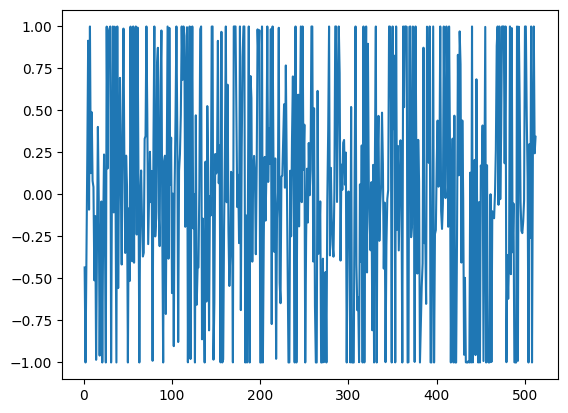

In [ ]:
# plotting the embedding 
x = [i for i in range(1,513)]
plt.plot(x,mn['tt0040067'])
plt.show()